In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pandas as pd

from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

from sklearn.metrics import balanced_accuracy_score, confusion_matrix

import sklearn
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math

# custom function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
# some_file.py
import sys
#change location to GNN_RIVM folder
sys.path.insert(1, '/home/jeroen/Documents/Toxic/GNN_rivm/benchmark')

from nets.TUs_graph_classification.load_net import gnn_model # import GNNs
from data.data import LoadData # import dataset
from train.train_TUs_graph_classification import train_epoch, evaluate_network, evaluate_network2 # import train functions

drop_last = False
device = torch.device("cpu")

In [1]:
def create_net_params(file_name):
    f = open(file_name, "r")
    n_params = (f.readlines()[5].split(" "))
    net_params = dict()
    pbt_params_int = ['in_dim', 'hidden_dim', 'out_dim', 'n_classes', 'L']
    int_idx = [27,3,5,29,1]
    pbt_params_str = ['readout', 'graph_norm', 'batch_norm', 'residual']
    str_idx = [9,15,17,7]
    
    for idx1, par in enumerate(pbt_params_int):
        net_params[par] = int(n_params[int_idx[idx1]].split(',')[0])
    net_params['dropout'] = float(n_params[13].split(',')[0])
    for idx2, par in enumerate(pbt_params_str):
        net_params[par] =  n_params[str_idx[idx2]].split(',')[0].strip("'")
    return net_params 

In [2]:
folder = "GatedPBTn/"
model_str = "GatedGCN"

gin1_file = "GatedGCN_PBT_Repn1_GPU0_17h16m43s_on_Jul_04_2020"
gin2_file = "GatedGCN_PBT_Repn2_GPU0_22h10m56s_on_Jul_03_2020"
gin3_file = "GatedGCN_PBT_Repn3_GPU0_21h16m45s_on_Jul_02_2020"
gin4_file = "GatedGCN_PBT_Repn4_GPU0_22h10m53s_on_Jul_03_2020"

In [3]:
gin1_np = create_net_params(folder+"config_"+gin1_file+".txt")
gin2_np = create_net_params(folder+"config_"+gin2_file+".txt")
gin3_np = create_net_params(folder+"config_"+gin3_file+".txt")
gin4_np = create_net_params(folder+"config_"+gin4_file+".txt")

In [4]:
print(gin1_np)
print(gin2_np)
print(gin3_np)
print(gin4_np)

{'in_dim': 15, 'hidden_dim': 196, 'out_dim': 196, 'n_classes': 2, 'L': 2, 'dropout': 0.5, 'readout': 'mean', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 23, 'hidden_dim': 96, 'out_dim': 96, 'n_classes': 2, 'L': 4, 'dropout': 0.5, 'readout': 'mean', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 19, 'hidden_dim': 16, 'out_dim': 64, 'n_classes': 2, 'L': 2, 'dropout': 0.5, 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 86, 'hidden_dim': 96, 'out_dim': 96, 'n_classes': 2, 'L': 6, 'dropout': 0.5, 'readout': 'mean', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [6]:
dataset1 = LoadData("PBT_Repn1")
dataset2 = LoadData("PBT_Repn2")
dataset3 = LoadData("PBT_Repn3")
dataset4 = LoadData("PBT_Repn4")

971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn1
Time taken: 9.4833s
971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn2
Time taken: 20.1315s
971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn3
Time taken: 17.1273s
971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn4
Time taken: 10.3543s


In [7]:
drop_last = True
device = torch.device("cpu")

In [8]:
def test_model(net_params, model_name, dataset, model_str):
    accs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
#         train_loader = DataLoader(trainset, batch_size=20, shuffle=True, drop_last=drop_last, collate_fn=dataset.collate)
#         val_loader = DataLoader(valset, batch_size=20, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, epoch_val_acc = evaluate_network(model, device, test_loader, 999)
        accs.append(epoch_val_acc)
    print(np.mean(accs),np.std(accs))
#     print(accs)

In [9]:
def test_model2(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.extend(score)
        labs.extend(labels)
    return accs, labs

In [10]:
def test_model3(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.append(score)
        labs.append(labels)
    return accs, labs

In [11]:
# gin1_np['L'] = 6
gin4_np['L'] = 4
print(gin4_np)

{'in_dim': 86, 'hidden_dim': 96, 'out_dim': 96, 'n_classes': 2, 'L': 4, 'dropout': 0.5, 'readout': 'mean', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [12]:
test_model(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
test_model(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
test_model(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
test_model(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

0.8948467230443974 0.04665608589615118
0.89404904033495 0.053777950185556866
0.9011775069435808 0.052830320773137755
0.9091056253368155 0.053309813896220325


In [13]:
accs1, labels1 = test_model2(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
accs2, labels2 = test_model2(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
accs3, labels3 = test_model2(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
accs4, labels4 = test_model2(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

In [14]:
acclist1, lablist1 = test_model3(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
acclist2, lablist2 = test_model3(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
acclist3, lablist3 = test_model3(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
acclist4, lablist4 = test_model3(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

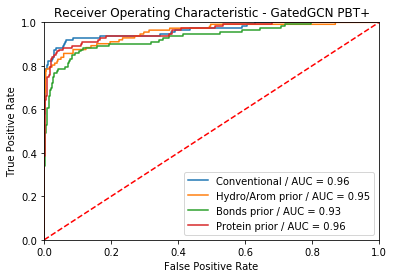

In [15]:
accuracies = [accs1, accs2, accs3, accs4]
acclists = [acclist1, acclist2, acclist3, acclist4]

labels = ["Conventional", "Hydro/Arom prior", "Bonds prior", "Protein prior"]
for idx, ac in enumerate(accuracies):
    fpr, tpr, threshold = metrics.roc_curve(labels1, sigmoid(np.array(ac))[:,1])
    roc_auc = metrics.roc_auc_score(labels1, sigmoid(np.array(ac))[:,1])
    plt.title('Receiver Operating Characteristic - GatedGCN PBT+')
    plt.plot(fpr, tpr, label = labels[idx]+' / AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
for acc in acclists:
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc):
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
#     print(rec)
    print("%.4f %.4f" % (np.mean(pre), np.mean(rec)))
#     print("%.4f" % np.mean(pre), np.std(pre))

0.9717 0.7932
0.9515 0.7939
0.8069 0.8303
0.7988 0.8485


In [17]:
from collections import Counter
idx_wrong = []
idx_wrong2 = []
for acc in accuracies:
    idx_wrong.append(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    idx_wrong2.extend(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    
idx_allwrong  = sorted(list(set(idx_wrong[0])&set(idx_wrong[1])&set(idx_wrong[2])&set(idx_wrong[3])))
print(Counter(Counter(idx_wrong2).values()))
print(Counter(idx_wrong2))

Counter({1: 35, 2: 20, 4: 11, 3: 7})
Counter({7: 4, 105: 4, 201: 4, 205: 4, 391: 4, 398: 4, 489: 4, 496: 4, 584: 4, 590: 4, 688: 4, 196: 3, 203: 3, 295: 3, 495: 3, 685: 3, 870: 3, 878: 3, 164: 2, 488: 2, 778: 2, 858: 2, 881: 2, 99: 2, 100: 2, 585: 2, 679: 2, 684: 2, 969: 2, 970: 2, 119: 2, 144: 2, 195: 2, 580: 2, 712: 2, 773: 2, 776: 2, 948: 2, 0: 1, 779: 1, 788: 1, 25: 1, 332: 1, 883: 1, 40: 1, 116: 1, 147: 1, 156: 1, 350: 1, 355: 1, 420: 1, 533: 1, 575: 1, 579: 1, 676: 1, 677: 1, 722: 1, 956: 1, 10: 1, 95: 1, 97: 1, 109: 1, 193: 1, 218: 1, 289: 1, 306: 1, 530: 1, 601: 1, 607: 1, 694: 1, 701: 1, 772: 1, 892: 1})


In [18]:
a = idx_allwrong
a.extend([105, 193, 195, 203, 218, 391, 398, 495, 679, 688, 694, 948, 969,117, 151, 157, 402,117, 151, 157, 199, 207, 303, 392, 401, 402])
print(Counter(a))

Counter({105: 2, 391: 2, 398: 2, 688: 2, 117: 2, 151: 2, 157: 2, 402: 2, 7: 1, 201: 1, 205: 1, 489: 1, 496: 1, 584: 1, 590: 1, 193: 1, 195: 1, 203: 1, 218: 1, 495: 1, 679: 1, 694: 1, 948: 1, 969: 1, 199: 1, 207: 1, 303: 1, 392: 1, 401: 1})


In [19]:
check_list = [196, 203, 295, 495, 685, 870, 878]
print(np.array(labels1)[check_list])
print(sigmoid(np.array(accs1))[check_list])
print(sigmoid(np.array(accs2))[check_list])
print(sigmoid(np.array(accs3))[check_list])
print(sigmoid(np.array(accs4))[check_list])

[1 1 1 1 1 0 1]
[[0.62810011 0.30096473]
 [0.96116033 0.01211151]
 [0.71792594 0.2892124 ]
 [0.92980207 0.13387642]
 [0.74176785 0.31818198]
 [0.24688837 0.82857263]
 [0.66600953 0.39735899]]
[[0.82218503 0.2926256 ]
 [0.96281212 0.09405925]
 [0.73665275 0.32385414]
 [0.69855889 0.17850052]
 [0.87979984 0.26290192]
 [0.43581498 0.29457313]
 [0.62386237 0.31862791]]
[[0.58666368 0.6080501 ]
 [0.21741339 0.74441196]
 [0.83583918 0.43981206]
 [0.92915058 0.52639371]
 [0.86116974 0.34124674]
 [0.49410539 0.70373675]
 [0.75330823 0.59620181]]
[[0.93798031 0.16816318]
 [0.86957398 0.24592238]
 [0.29661751 0.55540152]
 [0.38499452 0.54800585]
 [0.4838769  0.4911908 ]
 [0.04776388 0.88332583]
 [0.06161215 0.83207303]]


In [20]:
test = [15,26,54,57,62,65,70,71,88,90,93,109,135,142,151,175,177,178,179,198,208,222,232,248,249,251,280,286,310,320,324,356,372,377,378,402,404,406,408,418,423,439,440,443,462,472,477,492,505,506,544,552,554,568,577,585,607,611,624,633,640,669,681,687,692,713,717,729,735,746,752,755,761,770,777,782,785,787,805,817,826,853,857,862,870,886,897,898,919,926,927,935,936,947,957,961,967,969,
4,11,18,28,31,61,68,72,74,75,84,107,117,122,141,143,145,161,166,184,188,189,190,193,194,196,209,221,230,321,322,323,325,327,339,343,347,359,362,366,371,387,393,398,403,414,426,444,445,450,454,458,469,489,493,495,523,536,556,565,591,593,602,613,619,628,630,634,651,655,656,661,666,680,718,723,727,745,765,769,778,784,789,797,800,801,821,823,827,847,866,890,905,906,930,934,948,966,
19,34,45,48,49,53,76,81,83,95,102,114,119,156,167,172,181,182,191,202,213,243,245,247,260,267,270,276,277,293,304,308,311,316,330,351,392,410,412,421,428,431,438,446,475,480,517,521,528,529,537,538,541,542,543,546,559,563,576,590,595,597,599,609,612,637,639,644,649,660,679,684,696,703,725,747,776,781,796,806,809,818,837,855,868,879,884,885,904,913,915,918,924,925,946,951,958,
8,10,23,30,42,59,82,100,104,105,110,118,130,136,140,153,163,168,173,185,186,195,201,204,216,220,225,226,244,252,257,275,285,288,294,305,332,335,346,360,376,384,397,411,435,448,456,463,464,467,471,473,474,479,487,508,524,532,534,540,548,560,561,569,579,589,594,641,642,647,664,671,690,693,702,706,707,733,742,762,763,783,824,825,830,834,850,856,871,877,889,895,900,901,912,923,931,
3,20,21,29,32,36,47,50,52,64,80,112,115,121,123,127,134,154,155,180,187,200,205,206,229,237,238,265,279,289,290,296,300,315,333,334,348,349,350,361,368,369,383,389,390,396,401,436,441,447,452,468,494,500,507,510,516,545,551,557,562,574,580,625,626,638,643,645,646,650,654,657,659,682,694,697,701,708,756,768,780,799,808,819,822,833,842,851,852,861,863,864,869,875,903,955,962,
5,39,40,41,44,60,69,91,92,94,106,124,131,137,150,158,162,169,171,212,219,228,236,253,254,256,261,281,284,287,291,297,307,340,357,373,375,380,386,416,417,419,422,424,430,432,433,453,461,465,466,481,482,483,502,511,519,520,535,555,558,582,598,605,606,618,631,653,663,670,688,691,695,699,700,715,716,732,734,748,750,774,792,828,832,858,878,892,893,907,909,914,940,960,963,965,970,
9,12,24,33,43,66,67,79,96,97,108,120,128,129,138,148,149,157,160,165,215,223,227,231,239,263,264,266,269,274,283,292,302,306,319,337,338,341,365,367,395,399,413,415,434,476,486,515,531,533,549,564,581,592,615,623,627,629,635,648,698,705,709,710,711,714,722,730,740,741,743,767,771,788,803,804,807,810,815,829,843,845,849,854,874,876,880,891,922,938,939,941,942,943,944,952,956,
2,14,16,17,22,37,38,56,63,73,99,224,234,235,241,255,258,259,262,295,298,309,314,331,336,344,345,358,370,374,379,391,394,405,409,429,437,459,460,470,485,488,496,498,512,514,522,526,527,550,553,575,584,600,608,617,621,662,683,719,720,721,728,736,737,738,739,744,749,751,753,760,764,772,779,790,791,794,816,820,835,844,872,873,882,896,899,908,910,920,928,929,933,937,945,954,959,
1,6,27,58,77,86,87,89,101,103,111,116,126,139,144,147,152,159,164,174,176,197,207,210,240,246,250,268,271,282,299,312,313,318,328,329,342,352,354,363,381,400,407,449,490,491,503,504,509,518,530,567,572,573,583,601,604,610,614,632,636,652,658,665,668,675,685,686,689,704,724,731,754,757,759,766,786,795,802,813,831,836,838,839,840,846,848,860,865,867,902,911,921,932,949,950,968,
0,7,13,25,35,46,51,55,78,85,98,113,125,132,133,146,170,183,192,199,203,211,214,217,218,233,242,272,273,278,301,303,317,326,353,355,364,382,385,388,420,425,427,442,451,455,457,478,484,497,499,501,513,525,539,547,566,570,571,578,586,587,588,596,603,616,620,622,667,672,673,674,676,677,678,712,726,758,773,775,793,798,811,812,814,841,859,881,883,887,888,894,916,917,953,964]


In [21]:
print(len(labels1))
print(list(np.array(test)[[150,201,205,306,496,607,967,135,827]]))
print(np.array(labels1)[[150,201,205,306,496,607,967,135,827]])


971
[469, 53, 95, 136, 94, 231, 916, 359, 518]
[0 1 1 0 1 0 0 0 0]


In [22]:
print(sorted(list(set(idx_wrong[0])&set(idx_wrong[1])&set(idx_wrong[2])&set(idx_wrong[3]))))
print()

[7, 105, 201, 205, 391, 398, 489, 496, 584, 590, 688]



In [15]:
accuracies = [accs1, accs3, accs2, accs4]
for acc in accuracies:
    print(confusion_matrix(labels1, np.argmax(acc, axis=1)))

[[856   3]
 [ 23  89]]
[[835  24]
 [ 19  93]]
[[854   5]
 [ 23  89]]
[[833  26]
 [ 17  95]]


In [24]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        acc_temp.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(acc_temp), np.std(acc_temp)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.2f+/-%.2f" % (100*a[1],100*a[2]))
rep123=[]
rep124=[]
rep1234=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.2f+/-%.2f" % (100*np.mean(rep123), 100*np.std(rep123)))
print("%.2f+/-%.2f" % (100*np.mean(rep124), 100*np.std(rep124)))
print("%.2f+/-%.2f" % (100*np.mean(rep1234), 100*np.std(rep1234)))

89.48+/-4.67
91.21+/-4.22
91.30+/-4.17
90.56+/-5.24
89.52+/-4.45
89.52+/-4.45
91.22+/-4.87


In [27]:
acclists = [acclist1, acclist3, acclist2, acclist4]
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(pre), np.mean(rec)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.1f %.1f" % (100*a[1],100*a[2]))
rep123r=[]
rep124r=[]
rep1234r=[]
rep123p=[]
rep124p=[]
rep1234p=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist2[idx])))/3
    rep123r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep123p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/3
    rep124r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep124p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep1234p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.1f %.1f" % (100*np.mean(rep123p), 100*np.mean(rep123r)))
print("%.1f %.1f" % (100*np.mean(rep124p), 100*np.mean(rep124r)))
print("%.1f %.1f" % (100*np.mean(rep1234p), 100*np.mean(rep1234r)))

97.2 79.3
97.5 83.0
96.5 82.9
92.9 82.0
97.3 79.4
94.0 84.7
95.8 83.0


In [28]:
GIN3 = [[[-4.721020698547363, -3.720705270767212], [-8.45724105834961, -4.8628129959106445], [-10.08454704284668, -5.315932273864746], [-8.893217086791992, -5.681243419647217], [2.534881114959717, 8.739649772644043], [-14.00106430053711, -4.666454315185547], [-7.721632957458496, -4.83927583694458], [4.642420291900635, 5.456589698791504], [-10.731415748596191, -4.415062427520752], [-4.481880187988281, -3.583983898162842], [-8.89305305480957, -3.251411199569702], [-4.419035911560059, 5.804592132568359], [1.1996421813964844, 0.25223588943481445], [-1.7749829292297363, -4.09908390045166], [8.817302703857422, -7.345279693603516], [0.3375486135482788, 0.0569157600402832], [-7.868896961212158, -15.340539932250977], [0.08597353100776672, -1.972019910812378], [35.854156494140625, 8.00444221496582], [15.371685981750488, -1.5615471601486206], [-8.78857421875, -12.867630004882812], [3.1830995082855225, 3.081329345703125], [-3.0720152854919434, -5.292000770568848], [-6.809133529663086, -8.821115493774414], [-6.4632954597473145, -13.656179428100586], [-8.711679458618164, -13.153518676757812], [1.9845123291015625, 1.053274154663086], [-5.200796127319336, -9.063216209411621], [23.500629425048828, 6.954898834228516], [-1.4370039701461792, -1.884443998336792], [20.54343032836914, 3.690530776977539], [-1.4959406852722168, -6.21903133392334], [-0.2507438659667969, -2.9198198318481445], [9.349325180053711, -2.494088649749756], [9.246572494506836, -2.3914260864257812], [6.958860874176025, 5.003256797790527], [8.420422554016113, 2.0893282890319824], [-1.4512412548065186, -20.0010986328125], [-8.171659469604492, -8.254705429077148], [-4.584251880645752, -14.187623023986816], [-5.918899059295654, -8.738469123840332], [7.530050277709961, 0.39799147844314575], [-4.292270183563232, -9.722064018249512], [18.106769561767578, 4.188960075378418], [4.642279624938965, 1.2321548461914062], [4.4146318435668945, 1.708850383758545], [4.408261299133301, -5.498608589172363], [-5.506320476531982, -15.088841438293457], [18.587133407592773, -1.226069450378418], [19.24248504638672, -1.6082820892333984], [6.5531415939331055, -6.860762596130371], [15.456494331359863, 0.8322677612304688], [1.3836860656738281, -8.171366691589355], [2.6123080253601074, -8.329597473144531], [2.125197410583496, -0.046048641204833984], [43.23533630371094, 10.750728607177734], [12.592035293579102, 1.1748619079589844], [9.61263656616211, 1.9968464374542236], [3.771202564239502, 0.34573882818222046], [9.081287384033203, -2.591289520263672], [0.6712627410888672, -6.448105812072754], [11.794086456298828, 9.141905784606934], [5.131361484527588, 4.339392185211182], [3.147960901260376, 5.235198020935059], [3.9258155822753906, -1.9092378616333008], [0.2449970245361328, -16.114744186401367], [3.6109206676483154, 1.5779991149902344], [13.51014518737793, 4.4568772315979], [37.53415298461914, 17.2088680267334], [17.81116485595703, -1.5069398880004883], [30.988019943237305, 3.123382568359375], [9.829873085021973, -1.820828914642334], [43.09901428222656, 11.284334182739258], [2.935014009475708, -10.308588981628418], [18.961641311645508, 0.9217433929443359], [3.190910816192627, -3.127049684524536], [6.402952671051025, -0.6110841035842896], [13.411153793334961, 8.101309776306152], [-9.75855541229248, -21.300334930419922], [4.316929340362549, -1.7747687101364136], [10.467082977294922, 3.198863983154297], [3.9607014656066895, -1.996050477027893], [-1.0567612648010254, -4.654728412628174], [0.3799271583557129, -4.501535415649414], [16.50636863708496, 0.1213998794555664], [-0.4659407138824463, -4.241780757904053], [12.682195663452148, 6.99166202545166], [6.332067012786865, -7.960455417633057], [10.0110445022583, 5.81752872467041], [-0.6909157037734985, -2.2095980644226074], [-1.0991089344024658, -3.0752694606781006], [-2.354595184326172, -5.4792938232421875], [4.398183822631836, 0.5992188453674316], [-7.5843658447265625, -14.99929428100586], [-4.006115436553955, -13.77387809753418], [22.74835205078125, 10.32685375213623], [8.038257598876953, 3.2472119331359863], [-3.0303955078125, -5.411974906921387]], [[7.709496974945068, 9.159977912902832], [5.437329292297363, 8.709854125976562], [8.171847343444824, 11.41401481628418], [7.519623279571533, 11.871481895446777], [4.780383110046387, 12.982233047485352], [3.132014751434326, 11.02136516571045], [1.3624792098999023, 27.479934692382812], [6.550992488861084, 4.815732002258301], [5.806012153625488, 13.498878479003906], [3.497861862182617, 8.246631622314453], [-24.502159118652344, -15.147262573242188], [1.4897575378417969, 9.14732837677002], [15.732589721679688, 0.32629871368408203], [9.487881660461426, -6.770684242248535], [3.3187451362609863, -1.8479282855987549], [16.188859939575195, 7.809347629547119], [11.644514083862305, 4.054993629455566], [-5.135826110839844, -12.165452003479004], [-0.8247232437133789, -4.918639183044434], [7.817850112915039, 4.208525657653809], [1.65171217918396, -5.485300064086914], [9.324394226074219, 4.661906719207764], [8.517736434936523, 5.934621334075928], [5.5333967208862305, -3.668140411376953], [-4.645491600036621, -12.43191909790039], [-9.056530952453613, -13.245327949523926], [4.600865840911865, -1.8127050399780273], [13.747342109680176, -10.099979400634766], [8.254135131835938, 1.9157500267028809], [6.033722877502441, -14.316118240356445], [4.1461100578308105, -0.7689766883850098], [3.7175848484039307, 3.6326239109039307], [0.19117891788482666, -16.436046600341797], [-1.8303418159484863, -0.8571591377258301], [-4.082927703857422, -8.751286506652832], [3.18622088432312, -4.768282413482666], [-2.362301826477051, -7.960445404052734], [2.1868815422058105, 3.590048313140869], [12.141031265258789, 4.404688358306885], [1.3614076375961304, -8.096416473388672], [3.1864776611328125, -1.6148900985717773], [-11.193334579467773, -15.296494483947754], [18.071489334106445, 5.337899208068848], [4.351781845092773, -17.023418426513672], [-6.196266174316406, -13.474268913269043], [-0.9139995574951172, -13.02580451965332], [1.6985712051391602, 1.7354345321655273], [-4.191837310791016, -4.779143333435059], [5.936102867126465, 0.4691133499145508], [4.226993560791016, 3.055589437484741], [6.033699989318848, -4.635590553283691], [15.445619583129883, -4.387411594390869], [4.419595718383789, 6.253765106201172], [-8.958312034606934, -10.647550582885742], [1.6968612670898438, -30.49872589111328], [3.987539291381836, -11.919490814208984], [8.017786979675293, -5.1890153884887695], [9.490461349487305, 6.959939002990723], [9.745780944824219, 9.13100814819336], [9.938884735107422, -1.5752025842666626], [1.6357955932617188, -13.015291213989258], [10.596014022827148, 5.897035598754883], [13.690467834472656, -5.981268882751465], [18.308563232421875, -2.4688682556152344], [12.193143844604492, 3.393826961517334], [3.104250431060791, -0.15017271041870117], [10.564701080322266, 9.705286979675293], [7.34531307220459, 2.027623176574707], [11.088096618652344, 2.130284309387207], [17.155120849609375, -5.833504676818848], [6.121655464172363, -9.393133163452148], [12.372612953186035, 6.017705917358398], [12.044540405273438, 9.440317153930664], [7.681807518005371, 0.885384202003479], [12.9074125289917, -2.4682352542877197], [5.522792816162109, -7.005671501159668], [8.98489761352539, -1.1780076026916504], [21.063106536865234, -5.014836311340332], [0.43155598640441895, -9.149259567260742], [12.395145416259766, -3.269258499145508], [10.346814155578613, -1.3406633138656616], [13.792856216430664, 2.6525981426239014], [7.396474361419678, -1.5500752925872803], [14.558900833129883, 3.1818857192993164], [5.435548782348633, 1.5150800943374634], [12.085973739624023, 6.723807334899902], [11.319378852844238, 5.640338897705078], [16.535642623901367, 3.540820598602295], [6.591456413269043, -1.8580371141433716], [6.820499420166016, -0.9313609600067139], [4.848686218261719, -0.8355436325073242], [10.614093780517578, 7.293294429779053], [4.057598114013672, 1.6571345329284668], [9.751304626464844, 6.968899250030518], [9.962921142578125, 6.763228416442871], [3.6991422176361084, 5.3604888916015625], [1.833634853363037, -11.391383171081543], [6.991579055786133, 8.873562812805176]], [[-4.614010810852051, -3.8398118019104004], [-23.190858840942383, -15.093086242675781], [-23.14374542236328, -11.256660461425781], [-28.489269256591797, -12.567173957824707], [-28.489269256591797, -12.56717300415039], [15.645748138427734, 18.358341217041016], [-8.887876510620117, -0.3824547529220581], [11.271703720092773, 9.38482666015625], [-36.51021957397461, -20.33086395263672], [29.498016357421875, 33.47650146484375], [-21.15422248840332, -5.827603340148926], [38.25100326538086, 23.657236099243164], [34.55686950683594, 19.556169509887695], [-15.039141654968262, -19.144168853759766], [5.7813520431518555, -0.17584443092346191], [9.223140716552734, 8.43130874633789], [2.5073142051696777, -3.9658267498016357], [6.341561317443848, 2.1179347038269043], [14.018999099731445, 9.734447479248047], [-4.0180344581604, -12.865403175354004], [-13.751847267150879, -16.677215576171875], [-33.700870513916016, -34.0512809753418], [-9.988998413085938, -4.818521022796631], [-18.635116577148438, -20.545692443847656], [8.116929054260254, 1.5671496391296387], [93.50072479248047, 64.13186645507812], [-9.894084930419922, -14.580696105957031], [-4.1942853927612305, -13.0049409866333], [-10.975789070129395, -14.140445709228516], [-13.774874687194824, -18.065797805786133], [31.383270263671875, 23.69111442565918], [-14.345194816589355, -14.248261451721191], [-21.153980255126953, -24.028532028198242], [-0.3628721237182617, -18.303855895996094], [-18.17388343811035, -20.997814178466797], [-4.3386712074279785, -12.046241760253906], [-7.585886001586914, -19.152992248535156], [-14.414590835571289, -31.19586753845215], [9.789230346679688, -3.814520835876465], [13.773083686828613, 13.285961151123047], [-3.3072030544281006, -10.134391784667969], [0.5509421825408936, -4.975666046142578], [23.33688735961914, 11.386500358581543], [42.83519744873047, 30.043214797973633], [-60.031620025634766, -80.01009368896484], [49.05931854248047, 32.526405334472656], [8.565595626831055, 6.055245876312256], [54.31550598144531, 40.29540252685547], [-9.186596870422363, -20.316450119018555], [-0.6775574684143066, -10.25473403930664], [-4.908466339111328, -7.791705131530762], [-5.258816242218018, -6.475011348724365], [8.18945026397705, 3.7827067375183105], [8.1015625, 6.765872955322266], [7.1735429763793945, 0.05817985534667969], [-1.9406514167785645, -7.249890327453613], [35.065185546875, 31.903427124023438], [2.042599678039551, 3.8397281169891357], [13.172433853149414, 4.905482292175293], [38.34720993041992, 12.22633171081543], [14.828062057495117, 7.96469783782959], [40.8232421875, 33.92340850830078], [8.080523490905762, 0.3191039562225342], [23.9801025390625, 17.62490463256836], [24.80989646911621, 13.46221923828125], [25.370132446289062, 14.375636100769043], [18.566768646240234, 7.991659164428711], [9.935087203979492, -1.4666588306427002], [5.071207046508789, 8.252653121948242], [11.280058860778809, -2.6466894149780273], [48.55987548828125, 36.60059356689453], [54.75602722167969, 46.899654388427734], [-32.460391998291016, -44.47836685180664], [49.52042770385742, 43.07208251953125], [-10.453112602233887, -22.90298843383789], [40.931392669677734, 8.697006225585938], [0.46505165100097656, -13.363128662109375], [12.010749816894531, 3.9719042778015137], [45.66154479980469, 47.058441162109375], [66.17179107666016, 58.94126510620117], [-2.1619515419006348, -8.355649948120117], [31.953792572021484, 25.923999786376953], [43.85686111450195, 28.953521728515625], [-14.159843444824219, -15.265405654907227], [29.96620750427246, 22.93051528930664], [43.78776168823242, 33.8327522277832], [26.88521385192871, 21.90571403503418], [16.801677703857422, 12.204465866088867], [47.22807693481445, 36.01287841796875], [-2.993659496307373, -5.839016914367676], [-5.0195417404174805, -7.777778148651123], [8.735747337341309, 3.7790560722351074], [-4.42405891418457, -10.838156700134277], [-9.60860538482666, -9.028090476989746], [-14.451791763305664, -14.458398818969727], [-12.42573070526123, -15.692792892456055], [29.49802017211914, 33.47650146484375]], [[4.266493797302246, 6.157753944396973], [-4.239067077636719, 8.486273765563965], [3.433208465576172, 5.8204522132873535], [3.9061384201049805, 10.74744987487793], [0.4500713348388672, 7.411823272705078], [1.30214262008667, 12.617154121398926], [-0.7930483818054199, 4.15938663482666], [0.7663042545318604, 7.150640487670898], [2.7381882667541504, 6.332480430603027], [5.879153728485107, 12.937861442565918], [-1.5957164764404297, 3.7879600524902344], [-1.1364212036132812, -6.343623161315918], [4.119366645812988, -17.436115264892578], [3.5556938648223877, 5.96522331237793], [2.6717984676361084, -3.1314334869384766], [10.746047019958496, 3.662411689758301], [3.641397476196289, -0.39581727981567383], [9.779887199401855, 8.126690864562988], [8.099630355834961, -1.2271244525909424], [12.010322570800781, -4.607716083526611], [2.6687402725219727, -4.447482109069824], [2.4357194900512695, -1.3515057563781738], [5.735337257385254, 2.371086359024048], [2.973252534866333, -1.7472336292266846], [7.253966331481934, 4.20067834854126], [1.2129669189453125, -2.5364766120910645], [-0.626978874206543, 0.1823105812072754], [11.15904426574707, 4.276915550231934], [8.782829284667969, 1.0515093803405762], [6.012978553771973, 6.310531139373779], [4.064931392669678, -2.8525710105895996], [7.852486610412598, 5.745105743408203], [3.798863410949707, -3.5311832427978516], [6.188345432281494, -17.268123626708984], [2.390019178390503, -7.421696662902832], [14.670854568481445, -11.313326835632324], [6.6518402099609375, 2.4744319915771484], [5.736817359924316, -0.03844499588012695], [14.63776683807373, -0.12378430366516113], [1.4964799880981445, -3.9159598350524902], [-8.514789581298828, -30.31301498413086], [2.2129011154174805, -10.374052047729492], [10.848254203796387, -9.61015510559082], [12.722553253173828, -30.615619659423828], [6.070268630981445, 1.4431371688842773], [6.075838565826416, 1.0350298881530762], [0.881190299987793, -0.06278133392333984], [12.179655075073242, 6.199905872344971], [7.446904182434082, 4.420248031616211], [23.05694007873535, 2.122748374938965], [1.088879108428955, -2.780449390411377], [5.909832000732422, -11.400489807128906], [8.993386268615723, 2.724351167678833], [-21.32305145263672, -58.54665756225586], [2.7567789554595947, -5.702935218811035], [4.058865070343018, -7.469656944274902], [9.723642349243164, -8.548582077026367], [3.014834403991699, 2.658552408218384], [11.017258644104004, 1.3862725496292114], [3.586683750152588, -0.6584484577178955], [10.957891464233398, 2.1699397563934326], [6.706114768981934, -3.2013723850250244], [7.70380973815918, 5.803854465484619], [7.870202541351318, -0.7186378240585327], [11.017258644104004, 1.3862725496292114], [9.619325637817383, -9.879682540893555], [6.726032257080078, -0.6092022657394409], [6.190430164337158, -4.048497676849365], [2.858348846435547, -10.607282638549805], [5.642148971557617, 3.5198469161987305], [7.025247573852539, 0.4590113162994385], [1.1931524276733398, -7.519901275634766], [6.932094097137451, 2.2812604904174805], [5.300479888916016, -3.922642230987549], [5.092325687408447, -6.241715431213379], [7.365927219390869, 7.297365188598633], [7.838947772979736, -6.617271423339844], [9.46049976348877, -5.450906753540039], [8.307931900024414, 0.06471562385559082], [11.173393249511719, 0.6195311546325684], [7.96919059753418, -16.589324951171875], [11.932989120483398, 4.231849193572998], [5.65407657623291, -8.841485977172852], [8.442499160766602, -2.4364538192749023], [8.679557800292969, -3.603080987930298], [16.274486541748047, 10.071954727172852], [8.892243385314941, 3.223325490951538], [8.201512336730957, 0.830183207988739], [6.632294654846191, 0.8398513793945312], [9.413818359375, 0.9590702056884766], [4.758467674255371, 0.6761019825935364], [7.987815856933594, 3.6168997287750244], [10.610987663269043, 3.7664692401885986], [12.295074462890625, 1.8318071365356445], [5.87436056137085, 4.117013931274414], [5.960904121398926, 1.0973683595657349], [11.076730728149414, 7.200431823730469]], [[-5.626030921936035, -2.611175060272217], [12.187042236328125, -4.439657211303711], [0.8445816040039062, 4.462193489074707], [2.4176836013793945, 9.79566764831543], [-1.5345945358276367, 10.549949645996094], [7.255135536193848, 21.339488983154297], [-4.388033866882324, 10.562163352966309], [-4.387679100036621, 10.558035850524902], [8.509522438049316, 1.124442219734192], [4.5782318115234375, 18.614381790161133], [6.755425453186035, 15.747076034545898], [15.655261993408203, -4.303112030029297], [10.794418334960938, -12.09798812866211], [11.473149299621582, -6.258335590362549], [9.924280166625977, -3.74945068359375], [10.610428810119629, -12.843774795532227], [5.913822174072266, 0.2904484272003174], [19.580915451049805, -3.4937829971313477], [5.266324043273926, 1.1091606616973877], [-0.3603953719139099, -6.924778938293457], [6.226934432983398, -2.296097755432129], [10.38961410522461, -13.985820770263672], [3.6929643154144287, -0.9206576347351074], [9.870043754577637, 0.9051045179367065], [12.917299270629883, 6.399141311645508], [6.938816070556641, 2.615631103515625], [11.967235565185547, -7.441542625427246], [13.186216354370117, 6.498922824859619], [11.171993255615234, -14.488287925720215], [5.151037693023682, -7.373692512512207], [2.2179312705993652, -7.237963676452637], [4.887567520141602, -4.063880443572998], [15.954977035522461, -13.384346008300781], [15.305657386779785, 4.4197797775268555], [9.574728012084961, -2.543311834335327], [9.60073184967041, 4.297785758972168], [11.676998138427734, -12.460067749023438], [8.983092308044434, 2.286210298538208], [6.235933303833008, -1.5979617834091187], [7.214587211608887, -4.445491313934326], [8.399751663208008, 4.628100872039795], [14.360286712646484, -10.436651229858398], [17.76775550842285, 16.93414306640625], [10.283137321472168, 4.88039493560791], [1.0734970569610596, -11.931983947753906], [12.653144836425781, 8.86646842956543], [12.899778366088867, 8.731582641601562], [16.859554290771484, 5.719527244567871], [-5.644099235534668, -19.126123428344727], [15.330083847045898, -16.022541046142578], [7.1171064376831055, -8.14219856262207], [12.61354923248291, 3.6159884929656982], [0.6278696060180664, -22.273488998413086], [-6.55306339263916, -25.61827850341797], [-17.863014221191406, -41.286590576171875], [16.08904266357422, 5.09024715423584], [4.887991905212402, -23.779617309570312], [4.668299674987793, -7.039950847625732], [-10.663008689880371, -27.78459930419922], [14.853793144226074, 11.532602310180664], [5.19357442855835, -10.336779594421387], [6.7064900398254395, -0.14868950843811035], [10.9752197265625, -3.002305507659912], [14.026741027832031, 14.28219985961914], [13.347116470336914, 10.237021446228027], [12.146286964416504, -1.5498425960540771], [6.026637077331543, -5.345219612121582], [5.891714096069336, -4.993799209594727], [7.430597305297852, -21.134252548217773], [5.398327827453613, -5.342745780944824], [-1.6921262741088867, -14.135819435119629], [10.45541000366211, -1.5806275606155396], [7.110830307006836, -5.171076774597168], [0.09173774719238281, -21.62809181213379], [9.97710132598877, -6.630544185638428], [3.235569477081299, -6.7093963623046875], [5.372310161590576, -5.973055839538574], [11.80832290649414, -7.462709426879883], [-3.9948291778564453, -16.84067726135254], [8.890556335449219, -9.709135055541992], [9.553850173950195, -3.340148448944092], [8.87331485748291, 1.4829316139221191], [12.765443801879883, 3.5804338455200195], [-2.1081976890563965, -14.625123977661133], [12.72372817993164, 3.3901867866516113], [7.155648708343506, 2.9103057384490967], [17.69335174560547, 3.3435418605804443], [9.113951683044434, 0.5514161586761475], [18.970495223999023, 9.707286834716797], [7.069336891174316, 0.09116530418395996], [11.351177215576172, -11.212491989135742], [-2.424297332763672, -20.49634552001953], [9.755739212036133, 4.731082916259766], [18.16366195678711, 5.109556198120117], [12.053476333618164, 10.786628723144531], [10.404247283935547, 1.8078322410583496], [10.97352409362793, 9.876344680786133]], [[-0.8500242233276367, 2.8137378692626953], [-5.4394121170043945, -3.4466238021850586], [14.069774627685547, 14.073572158813477], [-7.134366035461426, -3.4970884323120117], [-18.359220504760742, 4.4802680015563965], [-6.00381326675415, 13.154566764831543], [-2.25518798828125, 1.2226295471191406], [-5.646078109741211, 16.9417724609375], [23.06869125366211, 22.535137176513672], [9.30224609375, 9.7720947265625], [0.4591444730758667, 18.46164894104004], [14.556844711303711, -3.0763235092163086], [41.974647521972656, 6.268157958984375], [7.690103530883789, -7.299777030944824], [10.19668197631836, -0.7653539180755615], [5.080263614654541, -17.432241439819336], [1.2034611701965332, -4.753596305847168], [8.900763511657715, -2.3476274013519287], [36.5706787109375, -22.92523956298828], [3.5967612266540527, -7.630390167236328], [46.121971130371094, 21.77283477783203], [-1.3862228393554688, -6.537199020385742], [1.065988540649414, -4.712381839752197], [4.388551712036133, -5.806288242340088], [3.9704508781433105, -0.10388803482055664], [1.9509340524673462, -2.7267680168151855], [31.457189559936523, -3.4927494525909424], [6.073645114898682, 1.299759864807129], [6.080520153045654, 0.4817190170288086], [32.89598083496094, 10.690007209777832], [13.471342086791992, 1.492551565170288], [4.3748979568481445, 0.18648862838745117], [-1.0451059341430664, -7.597456932067871], [8.753303527832031, -0.28069281578063965], [7.377523422241211, -2.5527679920196533], [2.784956693649292, 0.9510443210601807], [10.186698913574219, 1.4516901969909668], [9.10096263885498, 2.6009316444396973], [7.534229755401611, 5.4197468757629395], [7.336613655090332, -3.699860095977783], [1.1078708171844482, -1.0107738971710205], [42.88456344604492, 25.112464904785156], [23.02801513671875, 17.775575637817383], [6.758892059326172, 2.3415355682373047], [-0.7076187133789062, -5.465344429016113], [0.6959114074707031, -8.506914138793945], [-1.197924017906189, -7.401821136474609], [16.912487030029297, 2.3192391395568848], [3.9668800830841064, -0.2937760353088379], [11.993644714355469, 12.628995895385742], [8.245119094848633, -1.9908263683319092], [21.934200286865234, 2.3338818550109863], [31.100805282592773, 1.671785831451416], [19.84099769592285, -1.4075016975402832], [25.809293746948242, 8.889211654663086], [5.573860168457031, -19.777774810791016], [5.686915397644043, -15.69675350189209], [6.648367881774902, -14.511877059936523], [7.499045372009277, -1.6472184658050537], [19.729673385620117, 9.593746185302734], [7.560032367706299, 7.550899982452393], [5.014666557312012, -1.5707820653915405], [9.32424259185791, -1.3830835819244385], [6.095452308654785, -7.406609535217285], [15.150781631469727, 9.778833389282227], [9.51278305053711, 3.163691997528076], [6.888914108276367, -1.8381211757659912], [17.540468215942383, 7.509317398071289], [7.767153739929199, -1.2985055446624756], [13.304787635803223, 6.0301103591918945], [19.49639129638672, 13.91758918762207], [26.951295852661133, 18.87071990966797], [39.10337448120117, 17.429914474487305], [0.5077548027038574, 0.6121010780334473], [19.35540199279785, 3.5262279510498047], [29.930641174316406, 5.971066951751709], [5.988631725311279, 10.440596580505371], [21.550512313842773, 3.41705060005188], [4.931850433349609, 9.541297912597656], [7.292829513549805, -27.940258026123047], [23.965084075927734, 12.71567440032959], [-2.686617136001587, -3.621453285217285], [14.922191619873047, 4.836791038513184], [3.015777111053467, -1.7043399810791016], [11.009336471557617, 2.807720899581909], [13.47134017944336, 1.492548942565918], [2.9096314907073975, -4.924429893493652], [3.8892157077789307, -1.4252222776412964], [3.4516165256500244, 3.355398416519165], [39.75364303588867, 3.199808120727539], [3.96687912940979, -0.2937755584716797], [8.481149673461914, 7.917064189910889], [-1.2968101501464844, -0.3902416229248047], [-4.095407009124756, -6.181142807006836], [1.3405596017837524, -0.9002805948257446], [5.017932891845703, -5.634515762329102], [26.083934783935547, 4.892849445343018]], [[15.24822998046875, 15.383127212524414], [6.147974491119385, 7.819860935211182], [5.175285339355469, 14.078022956848145], [2.0788040161132812, 14.340106964111328], [0.5514521598815918, 7.675520896911621], [10.87099838256836, 22.177480697631836], [3.003399610519409, 6.1575727462768555], [-6.292551040649414, -1.1942238807678223], [8.07061767578125, 23.929603576660156], [9.712980270385742, 19.498811721801758], [4.534759521484375, 8.098369598388672], [13.77213191986084, -1.506324291229248], [-3.209636688232422, -20.241191864013672], [7.480192184448242, 1.6610599756240845], [11.175200462341309, 7.965426445007324], [13.508771896362305, 12.366792678833008], [-0.32609057426452637, -7.878552436828613], [16.872541427612305, 17.994983673095703], [13.671720504760742, 4.599430561065674], [1.0410957336425781, -4.156378746032715], [9.241291046142578, -0.27551233768463135], [11.315702438354492, 0.6818505525588989], [12.994672775268555, 8.56363296508789], [4.273148059844971, 4.549321174621582], [10.60162353515625, 0.7145822048187256], [11.559463500976562, 7.411860466003418], [10.987069129943848, 7.039694309234619], [14.348733901977539, 10.358400344848633], [24.863130569458008, 6.213143825531006], [18.754104614257812, 8.775322914123535], [4.376149654388428, 0.8276586532592773], [24.95936393737793, 11.238543510437012], [-1.706301212310791, -7.151010990142822], [16.52730369567871, 6.936322212219238], [2.003328323364258, -4.9784932136535645], [21.00165367126465, 11.233720779418945], [12.599331855773926, 5.66151237487793], [14.960380554199219, 1.7603563070297241], [11.06407642364502, 7.5832929611206055], [8.115191459655762, 2.213641405105591], [5.307285785675049, 2.0648040771484375], [22.6464900970459, 10.336774826049805], [9.488973617553711, 6.348075866699219], [-10.190351486206055, -41.93157958984375], [22.64944839477539, 12.931934356689453], [9.396990776062012, 2.3984336853027344], [5.958890438079834, 3.6248388290405273], [-56.557518005371094, -92.55712890625], [10.996953010559082, 4.7326531410217285], [18.6702880859375, 6.034824371337891], [10.343037605285645, 5.273695468902588], [4.738967418670654, 3.3661844730377197], [10.987068176269531, 7.0396928787231445], [33.49506378173828, 21.685604095458984], [4.068303108215332, 1.1306949853897095], [5.8718767166137695, 2.1608290672302246], [3.157689332962036, -0.23005259037017822], [-5.256880760192871, -8.458555221557617], [19.087806701660156, 10.1770658493042], [7.493267059326172, -4.924314498901367], [25.590604782104492, 14.042454719543457], [4.798447608947754, -7.537984371185303], [-1.894254207611084, -6.946585178375244], [18.625774383544922, 8.451546669006348], [6.529167652130127, 4.503353118896484], [15.041417121887207, 6.810632228851318], [9.634015083312988, -3.1279985904693604], [19.41603660583496, 16.921165466308594], [13.8525972366333, -5.4485931396484375], [-0.0009474754333496094, -14.104302406311035], [13.431184768676758, 9.593143463134766], [15.600919723510742, 2.8542916774749756], [17.678316116333008, 10.53956127166748], [11.595487594604492, 0.6415674686431885], [16.83393096923828, 10.11935806274414], [8.734107971191406, 2.268357992172241], [8.142171859741211, 5.0240302085876465], [6.196011543273926, 0.39405834674835205], [6.187010765075684, 0.38864338397979736], [6.467938423156738, 4.338506698608398], [8.90611457824707, 2.3120150566101074], [4.058407783508301, -4.013264179229736], [7.775755882263184, 5.799182415008545], [1.3848298788070679, -6.676167011260986], [10.890153884887695, 5.633078575134277], [10.55329704284668, 4.130631923675537], [10.597967147827148, 2.9570472240448], [21.00165367126465, 11.233720779418945], [24.952260971069336, 22.078227996826172], [15.400707244873047, 12.002195358276367], [24.932281494140625, 22.432350158691406], [7.608994483947754, 5.704800605773926], [14.728480339050293, 14.528144836425781], [6.431940078735352, 6.877463340759277], [8.40407657623291, 4.570464134216309], [13.150106430053711, 15.985154151916504], [5.6084160804748535, -0.11765623092651367]], [[5.294368267059326, 15.365827560424805], [5.450193405151367, 12.199644088745117], [12.055418014526367, 19.769901275634766], [19.91077423095703, 25.84772491455078], [22.196895599365234, 24.089801788330078], [17.100330352783203, 40.042564392089844], [18.29850959777832, 28.303977966308594], [16.69942855834961, 4.022965431213379], [9.70823860168457, 15.079440116882324], [4.806982040405273, 15.875125885009766], [12.092864990234375, 17.378032684326172], [-103.41874694824219, -139.72113037109375], [16.64165496826172, 7.456038475036621], [20.060836791992188, 20.828516006469727], [15.506861686706543, 7.452313423156738], [16.43528175354004, 14.502049446105957], [22.632049560546875, -1.452016830444336], [18.785127639770508, 10.39764404296875], [29.39267349243164, 14.353296279907227], [17.077049255371094, 9.46098518371582], [17.232128143310547, 6.344000816345215], [19.03506851196289, 9.634788513183594], [16.638427734375, 9.785533905029297], [30.78571128845215, 31.465383529663086], [21.99038314819336, 10.408679008483887], [15.707679748535156, -0.3310117721557617], [18.70568084716797, 2.688505172729492], [18.55010223388672, 15.050151824951172], [21.590747833251953, 15.44157600402832], [18.02290916442871, 8.64712142944336], [16.80830192565918, -9.42756175994873], [8.819110870361328, 7.804443359375], [19.706668853759766, 19.468700408935547], [17.964263916015625, 12.208066940307617], [16.33576774597168, 8.179340362548828], [15.716329574584961, -6.182319641113281], [17.052181243896484, -6.771492004394531], [17.6164608001709, -4.335236549377441], [14.591590881347656, 3.216784954071045], [-19.9619140625, -42.976226806640625], [13.172691345214844, 13.782430648803711], [18.17937469482422, 14.050202369689941], [15.144637107849121, 5.5203857421875], [11.874187469482422, -4.035240173339844], [-66.40874481201172, -87.6669921875], [-12.944829940795898, -35.33987808227539], [-2.1622791290283203, -21.186893463134766], [-13.27655029296875, -38.523746490478516], [10.822495460510254, -1.6573244333267212], [3.768479824066162, -5.791704177856445], [8.608551979064941, -8.520334243774414], [17.267742156982422, 7.704672813415527], [-0.43912601470947266, -16.83716583251953], [9.063973426818848, -1.4787342548370361], [17.239831924438477, 3.502821922302246], [12.444731712341309, 1.3657121658325195], [19.061634063720703, 7.387301445007324], [19.766563415527344, 7.562347888946533], [18.060638427734375, 15.291377067565918], [12.79871654510498, 3.781324863433838], [25.64956283569336, 16.45487403869629], [19.27075958251953, 11.863236427307129], [15.43423080444336, 5.307109832763672], [9.43790054321289, -7.955209732055664], [20.445180892944336, 10.351421356201172], [-2.9568605422973633, -26.474899291992188], [12.37725830078125, -3.8402857780456543], [15.656778335571289, 10.912585258483887], [-23.334346771240234, -57.48265838623047], [0.9406661987304688, -26.305158615112305], [15.918008804321289, 1.4528917074203491], [56.10772705078125, 35.43061447143555], [28.85176658630371, 12.08212947845459], [50.69634246826172, 22.913949966430664], [26.197471618652344, 11.592284202575684], [25.465585708618164, 11.812150955200195], [-19.46932601928711, -34.45841979980469], [21.047229766845703, 12.051382064819336], [3.1106550693511963, -4.266679763793945], [26.584911346435547, 16.524242401123047], [15.82894515991211, 10.27433967590332], [26.17784309387207, 16.118324279785156], [26.3998966217041, 18.399221420288086], [27.391172409057617, 24.328506469726562], [17.590444564819336, 9.402494430541992], [18.199129104614258, 14.067353248596191], [13.975309371948242, 7.546689987182617], [18.503087997436523, 13.230255126953125], [22.28655242919922, 17.56302261352539], [17.721078872680664, 4.530603885650635], [27.78919219970703, 23.372081756591797], [8.794824600219727, 8.175789833068848], [18.097671508789062, 14.918188095092773], [19.52751922607422, 12.621732711791992], [25.975250244140625, 19.46807861328125], [11.00270938873291, 7.665111064910889], [15.159992218017578, 9.25234603881836]], [[2.664473533630371, 3.621753454208374], [1.216719627380371, 11.427127838134766], [7.329083442687988, 18.999473571777344], [6.193632125854492, 18.0256290435791], [-2.6843879222869873, 0.8653964996337891], [1.533231496810913, 9.753246307373047], [-1.2358181476593018, 0.4202909469604492], [-2.708695888519287, 1.316032886505127], [3.7443318367004395, 9.948997497558594], [-6.753957748413086, -2.702293634414673], [0.9843711853027344, 10.593401908874512], [12.809595108032227, -1.6135449409484863], [10.129019737243652, -12.3057861328125], [6.527874946594238, 2.5538792610168457], [9.83499526977539, -5.067232131958008], [6.135059356689453, -3.728563070297241], [6.137314796447754, -2.2050280570983887], [13.151114463806152, 3.3605523109436035], [2.103484630584717, -18.652801513671875], [4.0270562171936035, -3.2258381843566895], [10.85498046875, -9.744231224060059], [4.763584136962891, -4.04304313659668], [2.541128158569336, -1.1693143844604492], [6.784480571746826, -0.4708123207092285], [2.392866611480713, -8.189291000366211], [6.649895191192627, 0.2512083053588867], [9.136678695678711, -0.267225980758667], [0.2929686903953552, -8.632607460021973], [2.6497631072998047, -2.5811352729797363], [4.836705684661865, -1.0334792137145996], [1.4960689544677734, -15.389957427978516], [7.843554496765137, -3.0303728580474854], [2.022952079772949, -7.188483238220215], [2.396195411682129, -2.9190139770507812], [1.1794757843017578, -1.5255513191223145], [1.4204885959625244, -1.2947893142700195], [8.603902816772461, -0.25304126739501953], [4.904090881347656, -9.178243637084961], [3.707751750946045, -12.310306549072266], [0.8429365158081055, -8.699278831481934], [7.869325637817383, 1.6540617942810059], [4.556337833404541, -14.548074722290039], [5.654348850250244, -1.1135997772216797], [13.103751182556152, 7.056069850921631], [8.816169738769531, 0.979283332824707], [3.7359814643859863, 1.3670854568481445], [10.816055297851562, 0.7561264038085938], [7.325310707092285, -2.9021072387695312], [3.4696831703186035, -9.74563217163086], [6.399984359741211, 6.405255317687988], [16.1138916015625, 7.113217353820801], [7.573691368103027, 2.251098871231079], [10.680255889892578, 8.159655570983887], [21.208999633789062, 9.030877113342285], [1.5390433073043823, -6.358095169067383], [-0.6621921062469482, -9.492671966552734], [7.25110387802124, -2.1123762130737305], [17.415645599365234, 6.457274436950684], [11.190817832946777, -5.116745471954346], [9.04712963104248, -2.939993143081665], [4.1339874267578125, -6.584144592285156], [21.035747528076172, 9.61022663116455], [13.877388000488281, 5.073355197906494], [5.635263442993164, -1.4015789031982422], [13.1707763671875, -1.8325693607330322], [-5.169661521911621, -23.90245819091797], [6.3287458419799805, -3.5993337631225586], [8.904423713684082, 9.326692581176758], [9.646074295043945, 7.571219444274902], [10.971409797668457, -6.0429792404174805], [17.559417724609375, 5.97202205657959], [6.539679050445557, -5.9338226318359375], [7.360592842102051, -5.6997222900390625], [17.8751277923584, 2.9488160610198975], [1.656750202178955, -14.085992813110352], [-1.6945619583129883, -14.845853805541992], [-5.622719764709473, -16.701040267944336], [1.7723197937011719, -2.4221975803375244], [7.162631511688232, -0.49631255865097046], [5.401730060577393, -4.769405364990234], [3.162994146347046, 1.0378295183181763], [12.4512939453125, 10.914920806884766], [2.2929635047912598, -4.138456344604492], [3.7634196281433105, -5.988653659820557], [7.266679763793945, -0.1960391402244568], [11.537467956542969, -3.0551860332489014], [4.783648490905762, -1.417236328125], [-4.778411388397217, -12.725509643554688], [1.8121490478515625, -4.697434425354004], [4.844893455505371, -1.1425220966339111], [1.1002633571624756, -5.357525825500488], [7.670414924621582, 4.927278995513916], [2.6070332527160645, 1.4505033493041992], [9.785319328308105, 6.028233528137207], [7.48876953125, 2.6001486778259277], [12.055816650390625, 9.216323852539062], [7.936671257019043, -2.472209930419922]], [[1.2363274097442627, 9.530549049377441], [3.236236810684204, 9.562284469604492], [7.736213684082031, 12.705068588256836], [14.65517520904541, 16.10820198059082], [-3.5573675632476807, 10.811006546020508], [20.439254760742188, 29.08579444885254], [8.629687309265137, 14.240965843200684], [20.234540939331055, 21.5352783203125], [4.384983062744141, 6.758553504943848], [-9.38536262512207, -4.107342720031738], [-0.4855947494506836, 9.800915718078613], [-6.835888862609863, -23.48087501525879], [5.105501174926758, -10.927155494689941], [4.8492536544799805, -16.535173416137695], [1.4393041133880615, -9.647905349731445], [-39.40008544921875, -55.52045440673828], [8.003189086914062, 5.381953239440918], [4.430719375610352, 1.9386241436004639], [10.863262176513672, -0.7039904594421387], [17.485885620117188, 12.209115982055664], [0.8623608350753784, -5.129276752471924], [-5.910735607147217, -22.01671028137207], [18.19842529296875, 12.938799858093262], [8.472278594970703, 4.298302173614502], [9.484325408935547, 3.8626465797424316], [4.62490177154541, 0.4477529525756836], [5.268970966339111, 5.203470230102539], [33.113731384277344, -12.35395622253418], [5.651650428771973, -3.503845453262329], [9.590164184570312, 3.3185372352600098], [-6.845762252807617, -20.09138298034668], [1.4042890071868896, -7.642877101898193], [7.988356590270996, -6.288196563720703], [9.414348602294922, 1.6208844184875488], [13.777384757995605, 13.32541561126709], [11.244025230407715, 2.571350336074829], [13.85017204284668, 1.630483627319336], [3.7824349403381348, -7.357480049133301], [9.546098709106445, -8.846593856811523], [5.650613784790039, 0.960538387298584], [14.598095893859863, 10.871849060058594], [8.022283554077148, 6.405941009521484], [-153.78439331054688, -184.5666961669922], [8.248419761657715, 2.3270726203918457], [6.092197895050049, -2.765376567840576], [8.040124893188477, 4.485476493835449], [7.243410587310791, 5.926523685455322], [3.856130599975586, -0.4458897113800049], [13.403328895568848, 13.763944625854492], [-1.1944246292114258, -11.087846755981445], [11.171375274658203, 6.23681640625], [-39.40008544921875, -55.52045440673828], [-51.89433288574219, -65.32123565673828], [-24.832347869873047, -39.928993225097656], [9.14261245727539, 0.6463110446929932], [11.33415699005127, 3.091064214706421], [-3.3716883659362793, -15.754114151000977], [5.128978729248047, -2.5211031436920166], [12.428756713867188, 3.1295554637908936], [3.89163875579834, -3.35111141204834], [-12.710277557373047, -28.929006576538086], [-5.669971466064453, -19.648700714111328], [-16.324073791503906, -29.39574432373047], [14.484758377075195, 3.7678773403167725], [5.270288467407227, -15.474767684936523], [4.888772487640381, -2.792879343032837], [-1.6823134422302246, -8.077624320983887], [8.388014793395996, 3.229045867919922], [1.997566819190979, -11.565185546875], [2.307292938232422, -4.852194786071777], [10.025278091430664, 4.915101051330566], [3.429992914199829, -2.9687302112579346], [2.2555723190307617, -7.8328070640563965], [14.235244750976562, 16.170812606811523], [2.3799750804901123, -7.528963565826416], [-1.6612751483917236, -6.053404808044434], [8.965995788574219, -7.3611063957214355], [15.661126136779785, 5.659547328948975], [-2.2146167755126953, -16.47930908203125], [-28.287508010864258, -52.78101348876953], [14.765368461608887, 5.530712604522705], [-0.9568199515342712, -1.8778235912322998], [13.324628829956055, 7.366753578186035], [5.758596420288086, -5.699416160583496], [-5.930453300476074, -11.561197280883789], [13.769453048706055, 4.409337997436523], [3.740257978439331, -3.4936304092407227], [13.015674591064453, 8.941625595092773], [5.496279239654541, -4.274655342102051], [9.076533317565918, 5.771806716918945], [12.815613746643066, 8.58638858795166], [-16.86745834350586, -29.322364807128906], [3.7598400115966797, 4.393086910247803], [10.777339935302734, 6.970869541168213], [6.939389228820801, 7.744208335876465], [20.02946662902832, 15.764629364013672]]]

In [42]:
accs = []
bac = []
rec = []
pre = []
for idx, acc_fold in enumerate(GIN3):
    acc_samen = (sigmoid(np.array(GIN3[idx]))+sigmoid(np.array(acclist4[idx])))/2
    bac.append(sklearn.metrics.balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
accs.append([idx1, np.mean(pre), np.mean(rec), np.mean(bac)])
print(accs)

In [43]:
print(accs)

[[3, 0.8007264957264957, 0.8484848484848484, 0.9091124652820959]]


In [21]:
rep123=[]
rep124=[]
rep1234=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print(np.mean(rep123), np.std(rep123))
print(np.mean(rep124), np.std(rep124))
print(np.mean(rep1234), np.std(rep1234))

0.8952255109231853 0.044461094037135
0.8952255109231853 0.044461094037135
0.9122308585167682 0.048706663759302105


In [22]:
accs = []
for idx1, acc1 in enumerate(accuracies):
    pred = []
    acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(acc1)))/2
    print(idx1+1)
    print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

1
[[856   3]
 [ 23  89]]
2
[[855   4]
 [ 19  93]]
3
[[856   3]
 [ 19  93]]
4
[[851   8]
 [ 20  92]]


In [23]:
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

[[856   3]
 [ 23  89]]
[[853   6]
 [ 18  94]]
[[854   5]
 [ 19  93]]
